In [65]:
import pandas as pd
import os
import matplotlib.pyplot as plt

DATA_PATH = "../ml-latest-small"

In [66]:
movies_df = pd.read_csv(os.path.join(DATA_PATH, "movies.csv"))

movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [67]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, "ratings.csv"))

ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [68]:
# Espansione dei generi in colonne binarie
movies_with_genres = movies_df.copy()
movies_with_genres['genres'] = movies_with_genres['genres'].str.split('|')

movies_with_genres.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [69]:
from collections import Counter

# Sostituisci '(no genres listed)' con una stringa unica per evitare problemi durante la separazione
movies_df['genres'] = movies_df['genres'].replace('(no genres listed)', 'No_genres_listed')

# Crea una lista di tutti i generi
all_genres = '|'.join(movies_df['genres']).split('|')

# Conta le occorrenze di ciascun genere
genre_counts = Counter(all_genres)

# Crea un DataFrame a partire dal contatore
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

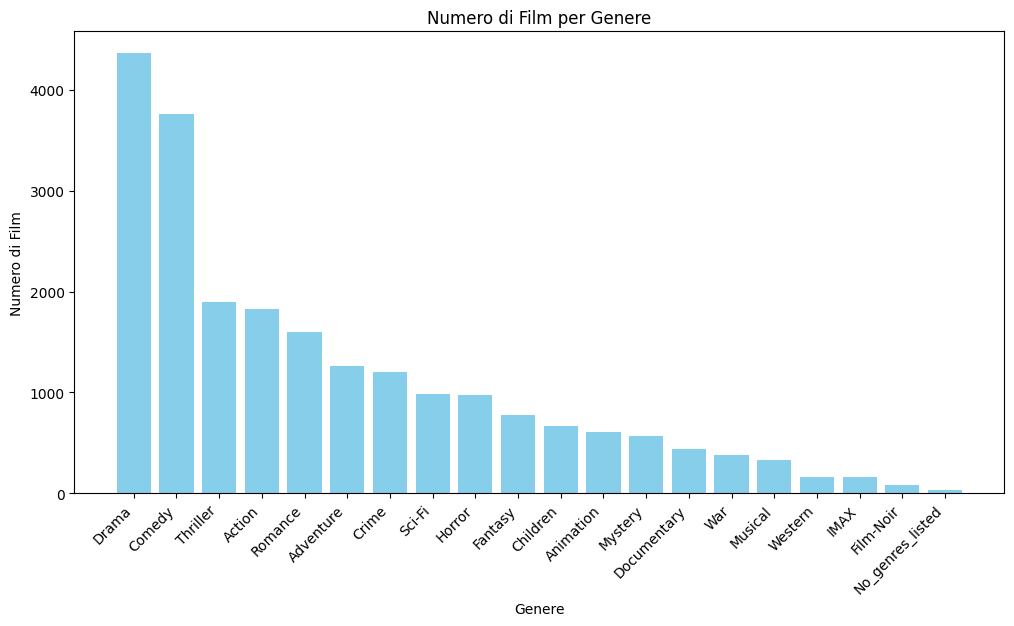

In [70]:
# Crea il grafico a barre
plt.figure(figsize=(12, 6))
plt.bar(genre_counts_df['Genre'], genre_counts_df['Count'], color='skyblue')
plt.xlabel('Genere')
plt.ylabel('Numero di Film')
plt.title('Numero di Film per Genere')
plt.xticks(rotation=45, ha='right')
plt.show()

In [71]:
# Estrai tutti i generi unici
all_genres = set()
for genres in movies_df['genres']:
    all_genres.update(genres.split('|'))

# Sicome dopo calcolo one-hot encoding, devo tenere questa colonna nel dizionario ma la vorrei per ultima (quindi tolgo e poi la riaggiungo dopo aver creato dizionario)
all_genres.remove('No_genres_listed')

# Crea un dizionario: nome_genere -> indice
genre_dict = {genre: idx for idx, genre in enumerate(sorted(all_genres), 1)}

genre_dict["No_genres_listed"] = len(all_genres)+1

print("Dizionario generi:", genre_dict)

Dizionario generi: {'Action': 1, 'Adventure': 2, 'Animation': 3, 'Children': 4, 'Comedy': 5, 'Crime': 6, 'Documentary': 7, 'Drama': 8, 'Fantasy': 9, 'Film-Noir': 10, 'Horror': 11, 'IMAX': 12, 'Musical': 13, 'Mystery': 14, 'Romance': 15, 'Sci-Fi': 16, 'Thriller': 17, 'War': 18, 'Western': 19, 'No_genres_listed': 20}


In [72]:
# Crea colonne binarie per i generi
genre_onehot = movies_df['genres'].str.get_dummies(sep='|')

# Moltiplica ogni colonna per il suo indice (1 diventa l'indice, 0 resta 0)
genre_encoded = genre_onehot.copy()
for genre in genre_encoded.columns:
    genre_encoded[genre] = genre_encoded[genre] * genre_dict[genre]

# Combina con movieId e title
movies_encoded = pd.concat([movies_df[['movieId', 'title']], genre_encoded], axis=1)

movies_encoded = movies_encoded.drop("No_genres_listed", axis=1)

movies_encoded.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,2,3,4,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,2,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,5,0,0,0,...,0,0,0,0,0,15,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,5,0,0,8,...,0,0,0,0,0,15,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Inserimento dei Tags

In [73]:
tags_df = pd.read_csv(os.path.join(DATA_PATH, "tags.csv"))

tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [74]:
# Combinare i tag per ogni film
tags_per_movie = tags_df.groupby('movieId')['tag']
# Creo tutti i tags univoci
tags_per_movie = tags_per_movie.apply(lambda x: ' '.join(set(x))).reset_index()

# Uniamo i tag combinati al dataframe dei film
movies_with_tags = pd.merge(movies_encoded, tags_per_movie, on='movieId', how='left')

# Gestiamo eventuali NaN nei tag (se un film non ha tag, mettiamo una stringa vuota)
movies_with_tags['tag'] = movies_with_tags['tag'].fillna('')

movies_with_tags.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,tag
0,1,Toy Story (1995),0,2,3,4,5,0,0,0,...,0,0,0,0,0,0,0,0,0,pixar fun
1,2,Jumanji (1995),0,2,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fantasy game Robin Williams magic board game
2,3,Grumpier Old Men (1995),0,0,0,0,5,0,0,0,...,0,0,0,0,15,0,0,0,0,old moldy
3,4,Waiting to Exhale (1995),0,0,0,0,5,0,0,8,...,0,0,0,0,15,0,0,0,0,
4,5,Father of the Bride Part II (1995),0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,remake pregnancy


## Suggerimento Modello da chat

qui ha già fatto un classificatore basato su TF-IDF (metrica che prende parole e pesa sia rarità che n° occorrenze) per valutare similarità tra due film.

Io integrerei anche la parte di categoria da usare sia assieme che in caso di mancanza di tags (due film con tag vuoti saranno molto simili, almeno vediamo categorie) per trovare modello generale

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Creiamo il vettore TF-IDF sui tag
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_with_tags['tag'])

# Calcoliamo la similarità del coseno tra i film
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Funzione per ottenere raccomandazioni basate sui tag
def get_movie_recommendations(movie_id, cosine_sim=cosine_sim, top_n=10):
    # Ottieni l'indice del film
    idx = movies_with_tags.index[movies_with_tags['movieId'] == movie_id].tolist()[0]

    # Ottieni la lista delle similarità per il film richiesto
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordina i film in base alla similarità e ottieni i top_n film simili
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Ottieni gli ID dei film consigliati
    movie_indices = [i[0] for i in sim_scores]

    # Restituisci i film consigliati
    recommended_movies = movies_with_tags[['movieId', 'title', 'tag']].iloc[movie_indices]
    return recommended_movies

# Esempio: ottenere raccomandazioni per il film con ID 1
recommended_movies = get_movie_recommendations(movie_id=1)
recommended_movies

,movieId,title,tag
1757,2355,"Bug's Life, A (1998)",Pixar
8695,122918,Guardians of the Galaxy 2 (2017),fun
2355,3114,Toy Story 2 (1999),original sequel funny Disney Pixar animation T...
8546,115617,Big Hero 6 (2014),feel-good kids fun family movie robots very fu...
8357,108932,The Lego Movie (2014),feel-good imaginative cheeky colorful clever q...
7693,89745,"Avengers, The (2012)",superhero silly visually appealing superhero t...
7039,68954,Up (2009),dreams cartoon adventure emotional heartbreaki...
257,296,Pulp Fiction (1994),drugs pop culture references Samuel L. Jackson...
1,2,Jumanji (1995),fantasy game Robin Williams magic board game
2,3,Grumpier Old Men (1995),old moldy


In [76]:
from sklearn.naive_bayes import MultinomialNB

# merge of ratings_df and tags_per_movie 
data = pd.merge(ratings_df, tags_per_movie, on='movieId')
data = data.dropna(subset=['tag'])

# Labeling the data, 1 for positive (rating >= 4), 0 for negative (rating <= 2) and None for neutral
data['label'] = data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
data = data.dropna(subset=['label'])
data['label'] = data['label'].astype(int)

# Create a TF-IDF vectorizer and transform the tags
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(data['tag'])
y = data['label']

# Train a logistic regression model
model = MultinomialNB()
model.fit(X, y)

# Function to recommend movies for a user
def recommend_for_user(user_id, top_n=10):
    user_seen = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    unseen_movies = tags_per_movie[~tags_per_movie['movieId'].isin(user_seen)].dropna()

    unseen_features = tfidf.transform(unseen_movies['tag'])
    probs = model.predict_proba(unseen_features)[:, 1]
    unseen_movies['score'] = probs

    unseen_movies = unseen_movies.merge(movies_df[['movieId', 'title']], on='movieId')

    return unseen_movies.sort_values('score', ascending=False).head(top_n)[['movieId', 'title', 'score']]

# Example: recommend movies for user with ID 1
recommendations = recommend_for_user(user_id=1)
print(recommendations)

      movieId                                              title     score
71        318                   Shawshank Redemption, The (1994)  0.996611
1256    48516                               Departed, The (2006)  0.993469
242      1193             One Flew Over the Cuckoo's Nest (1975)  0.986084
1035     7361       Eternal Sunshine of the Spotless Mind (2004)  0.984811
62        280                         Murder in the First (1995)  0.983641
282      1276                              Cool Hand Luke (1967)  0.983641
66        293  Léon: The Professional (a.k.a. The Professiona...  0.983593
157       904                                 Rear Window (1954)  0.981081
1326    79132                                   Inception (2010)  0.980383
1306    68157                        Inglourious Basterds (2009)  0.976721
